# Imports

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [167]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.7 MB/s 


In [168]:
import cv2
import numpy as np
import os
import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Configs

In [223]:
class configs:
  data_path = '/content/clothing-dataset-small/'
  model_out_path = '/content/drive/MyDrive/Tahaluf_CV_Task/'
  exp_name = 'exp5'
  
  batch_size = 32
  img_size = (224, 224)
  num_classes = 10
  class_names = ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']
  class_mapping = {'dress':0,
                    'hat':1,
                    'longsleeve':2,
                    'outwear':3,
                    'pants':4,
                    'shirt':5,
                    'shoes':6,
                    'shorts':7,
                    'skirt':8,
                    't-shirt':9}

  optimizer = 'Adam'
  learning_rate = 1e-4
  num_epochs = 200

# Download the data

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 384 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 27.46 MiB/s, done.
Resolving deltas: 100% (10/10), done.


# Data Visualization

In [71]:
def get_distribution(path, mode):
  dist_dict = {}
  classes = os.listdir(path + mode)

  for class_name in classes:
    dist_dict[class_name] = len(os.listdir(path + mode + '/' + class_name))
  return dist_dict

In [72]:
def plot_dist(data, title):
  plt_1 = plt.figure(figsize=(10, 6))
  plt.title(title)
  names = list(data.keys())
  values = list(data.values())

  plt.bar(range(len(data)), values, tick_label=names)
  plt.show()

In [73]:
train_dist = get_distribution(configs.data_path, 'train')
val_dist = get_distribution(configs.data_path, 'validation')
test_dist = get_distribution(configs.data_path, 'test')

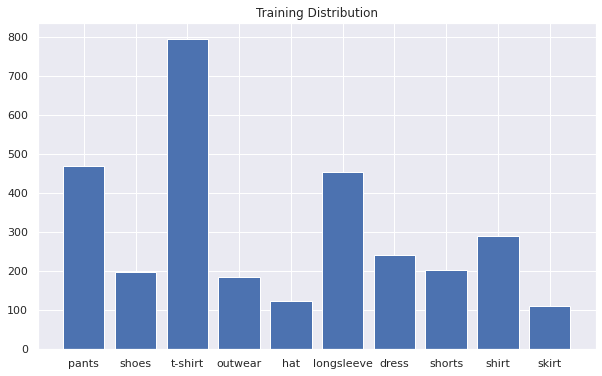

In [74]:
plot_dist(train_dist, 'Training Distribution')

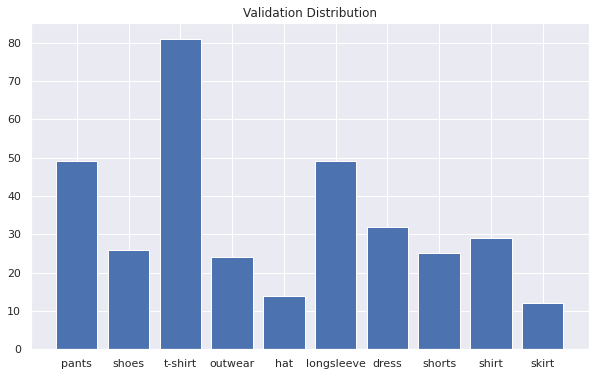

In [75]:
plot_dist(val_dist, 'Validation Distribution')

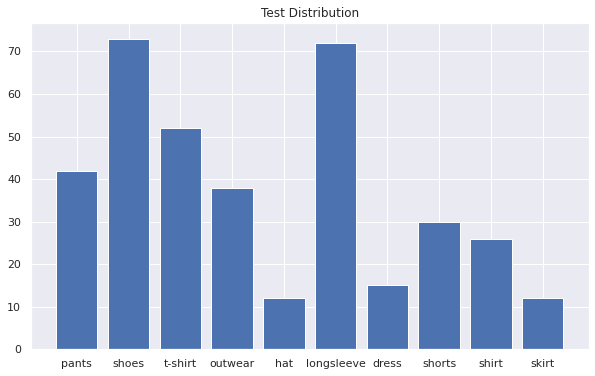

In [76]:
plot_dist(test_dist, 'Test Distribution')

# Prepare dataset

In [77]:
def get_generators(data_path, batch_size, img_size):

  train_dir = data_path + 'train'
  validation_dir = data_path + 'validation'
  test_dir = data_path + 'test'

  BATCH_SIZE = batch_size
  IMG_SIZE = img_size

  train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                              label_mode = 'categorical',
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)

  validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                  label_mode = 'categorical',
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

  test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            label_mode = 'categorical',
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)
  
  AUTOTUNE = tf.data.AUTOTUNE

  train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
  test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  return train_dataset, validation_dataset, test_dataset

In [78]:
train_dataset, validation_dataset, test_dataset = get_generators(configs.data_path, configs.batch_size, configs.img_size)

Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.
Found 372 files belonging to 10 classes.


# Model

In [224]:
def get_model(configs):

  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  ])

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

  IMG_SHAPE = configs.img_size + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  base_model.trainable = False

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  prediction_layer = tf.keras.layers.Dense(configs.num_classes, activation='softmax')

  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  print(model.summary())
  return model

In [225]:
model = get_model(configs)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

# Train

In [226]:
def train_model(configs, model ,train_dataset, validation_dataset):

  if configs.optimizer == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)

  best_acc_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=configs.model_out_path + configs.exp_name + '/best_acc.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

  best_loss_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=configs.model_out_path + configs.exp_name + '/best_loss.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

  model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              #loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=['accuracy'])
  
  history = model.fit(train_dataset,
                    epochs=configs.num_epochs,
                    validation_data=validation_dataset,
                    callbacks=[best_acc_callback, best_loss_callback])
  
  return history

In [227]:
def plot_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy Loss')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [228]:
history = train_model(configs, model, train_dataset, validation_dataset)

Epoch 1/200
95/96 [============================>.] - ETA: 0s - loss: 2.7194 - accuracy: 0.1523
Epoch 1: val_accuracy improved from -inf to 0.28152, saving model to /content/drive/MyDrive/Tahaluf_CV_Task/exp5/best_acc.hdf5

Epoch 1: val_loss improved from inf to 2.06080, saving model to /content/drive/MyDrive/Tahaluf_CV_Task/exp5/best_loss.hdf5
96/96 [==============================] - 11s 83ms/step - loss: 2.7164 - accuracy: 0.1529 - val_loss: 2.0608 - val_accuracy: 0.2815
Epoch 2/200
96/96 [==============================] - ETA: 0s - loss: 2.3108 - accuracy: 0.2477
Epoch 2: val_accuracy improved from 0.28152 to 0.42815, saving model to /content/drive/MyDrive/Tahaluf_CV_Task/exp5/best_acc.hdf5

Epoch 2: val_loss improved from 2.06080 to 1.73216, saving model to /content/drive/MyDrive/Tahaluf_CV_Task/exp5/best_loss.hdf5
96/96 [==============================] - 8s 76ms/step - loss: 2.3108 - accuracy: 0.2477 - val_loss: 1.7322 - val_accuracy: 0.4282
Epoch 3/200
96/96 [=====================

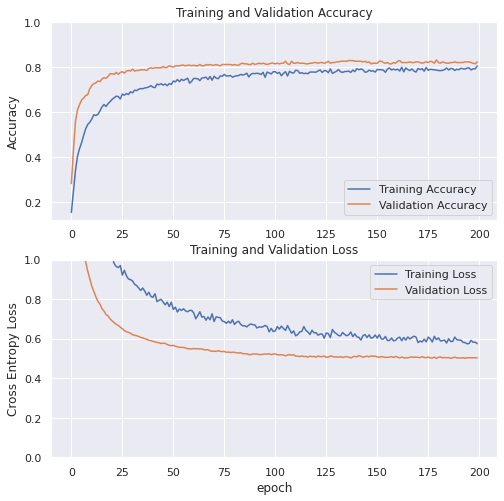

In [229]:
plot_learning_curves(history)

# Evaluation

In [230]:
def load_model(path):
  model = tf.keras.models.load_model(path)
  return model

In [231]:
def calc_metrics(configs, model, test_dataset):
  test_loss, test_accuracy = model.evaluate(test_dataset)
  print("Test loss: {}\nTest accuracy: {}".format(test_loss, test_accuracy))

  #Calculate precison, recall and F1-score
  X = []
  y = []
  test_classes = sorted(os.listdir(configs.data_path + 'test'))
  for test_class in test_classes:
    img_paths = sorted(os.listdir(configs.data_path + 'test' + '/' + test_class))
    for img_path in img_paths:
      img = cv2.imread(configs.data_path + 'test' + '/' + test_class + '/' + img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, configs.img_size)
      X.append(img)
      y.append(configs.class_mapping[test_class])

  X = np.array(X)
  y = np.array(y)
  print('Test X shape: {}\nTest y shape: {}'.format(X.shape, y.shape))
  y_preds = model.predict(X)
  y_preds_max = np.argmax(y_preds, axis=1)
  print(classification_report(y, y_preds_max, target_names=configs.class_names))

  #Calculate confusion matrix
  cm = confusion_matrix(y, y_preds_max)
  return cm

In [232]:
def plot_cm(configs, cm):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm, annot=True, cmap='Blues')
  sns.set(rc = {'figure.figsize':(12,12)})

  ax.set_title('Seaborn Normalized Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(configs.class_names)
  ax.yaxis.set_ticklabels(configs.class_names)

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [242]:
model = load_model('/content/drive/MyDrive/Tahaluf_CV_Task/exp2/best_acc.hdf5')

In [243]:
cm = calc_metrics(configs, model, test_dataset)

12/12 [==============================] - 2s 48ms/step - loss: 0.4641 - accuracy: 0.8548
Test loss: 0.46414491534233093
Test accuracy: 0.8548387289047241
Test X shape: (372, 224, 224, 3)
Test y shape: (372,)
              precision    recall  f1-score   support

       dress       0.73      0.73      0.73        15
         hat       0.90      0.75      0.82        12
  longsleeve       0.82      0.81      0.81        72
     outwear       0.75      0.87      0.80        38
       pants       0.88      1.00      0.93        42
       shirt       0.67      0.54      0.60        26
       shoes       1.00      0.99      0.99        73
      shorts       0.96      0.77      0.85        30
       skirt       1.00      0.75      0.86        12
     t-shirt       0.83      0.92      0.87        52

    accuracy                           0.86       372
   macro avg       0.85      0.81      0.83       372
weighted avg       0.86      0.86      0.86       372



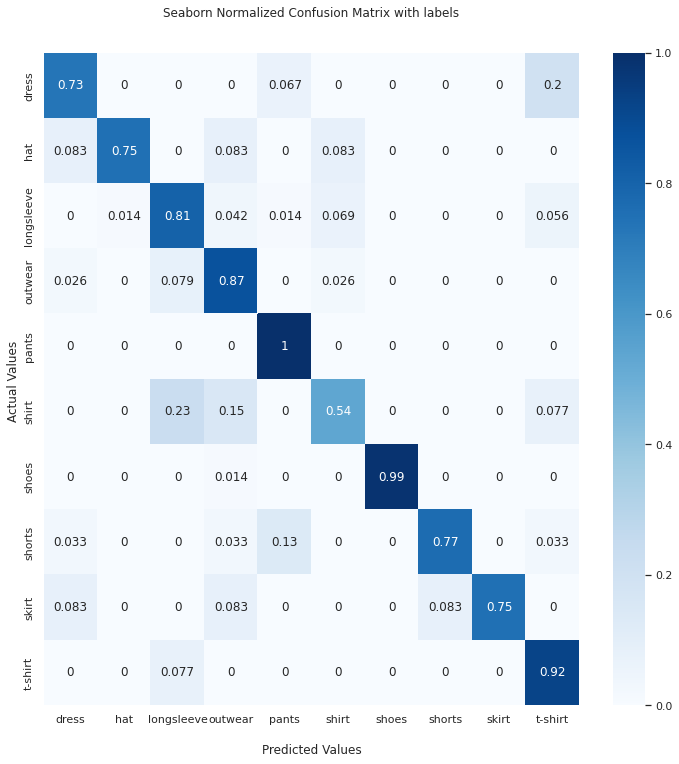

In [244]:
plot_cm(configs, cm)